## Objective 
(taken from Kaggle)

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

In [68]:
import numpy as np
import pandas as pd

from itertools import product ## Sort of gives us the cartesian product
from sklearn.preprocessing import LabelEncoder ## converting unique categories into numerical equalvalents

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

In [2]:
items = pd.read_csv('I:/ML Datasets/data-science-predict-future-sales/items.csv')
shops = pd.read_csv('I:/ML Datasets/data-science-predict-future-sales/shops.csv')
cats = pd.read_csv('I:/ML Datasets/data-science-predict-future-sales/item_categories.csv')
train = pd.read_csv('I:/ML Datasets/data-science-predict-future-sales/sales_train.csv',parse_dates = ['date'])
test = pd.read_csv('I:/ML Datasets/data-science-predict-future-sales/test.csv').set_index('ID')

## Data fields description:¶
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- date - date in format dd/mm/yyyy
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [3]:
## downcast_dtypes does save memory and we need it!
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train = downcast_dtypes(train)
print(train.info())

## Yeah bought the memory down to 61.6+ MB from 132MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int16         
 2   shop_id         int16         
 3   item_id         int16         
 4   item_price      float32       
 5   item_cnt_day    float32       
dtypes: datetime64[ns](1), float32(2), int16(3)
memory usage: 61.6 MB
None


# Explanatory Data Analysis

In [4]:
print(train['date'].min().date()) ## This is the start and end date for the training set...
print(train['date'].max().date())

2013-01-01
2015-12-10


In [5]:
train['date_block_num'].unique() ## These are codes given for each month from 2013- 2015

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int16)

The columns data block below creates a dataframe that has the months shown above in the columns and the vlaues of total products sold in the values. The Nan values are filled with 0. The first columns is that of the unique items that are sold across the stores and these are shown as item_id

In [6]:
## Pretty much has the item_id on the columns and number of months from Jan 2013 to Dec 2015

sales_by_itemsid = train.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                  columns = 'date_block_num', aggfunc = np.sum, fill_value = 0).reset_index()\
## There is multi-indexing here in which 
sales_by_itemsid.columns = sales_by_itemsid.columns.droplevel().map(str)
sales_by_itemsid = sales_by_itemsid.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_itemsid.columns.values[0] = 'item_id'
sales_by_itemsid

,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21802,22165,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
21803,22166,0,0,0,0,0,0,0,0,0,...,7,8,12,4,8,10,8,11,5,11
21804,22167,0,0,0,0,0,0,0,0,56,...,33,46,40,38,31,33,34,29,21,37
21805,22168,2,2,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


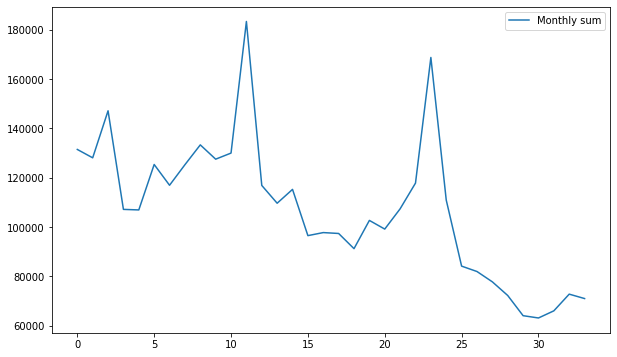

In [7]:
sales_by_itemsid.sum()[1:].plot(legend=True, label="Monthly sum" , figsize = (10,6))
## This is pretty much showing us that across each month the total amount of products sold keeps decreasing from the start
## of the training set.

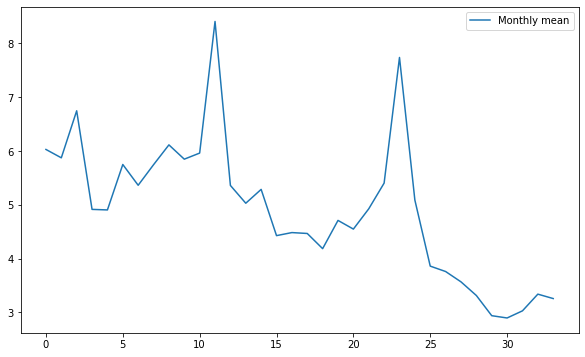

In [8]:
sales_by_itemsid.mean()[1:].plot(legend=True, label="Monthly mean" , figsize = (10,6))
## This is pretty much showing us that across each month the mean amount of products sold keeps decreasing from the start
## of the training set.

In [ ]:
print('Sale Volume Outliers:' train['item_id'])

In [54]:
## Item-id's with a sale volume count that is higher than 500
## Item-id's with a item price that are higher than 50000
print('Sale volume outliers:',train['item_id'][train['item_cnt_day']>500].unique())
print('Item price outliers:',train['item_id'][train['item_price']>50000].unique())

Sale volume outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
Item price outliers: [11365  6066 13199]


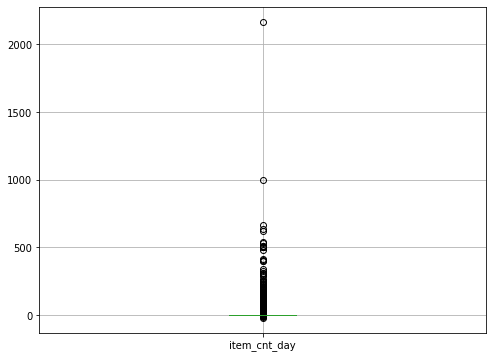

In [56]:
train.boxplot(column = 'item_cnt_day',figsize = (8,6))

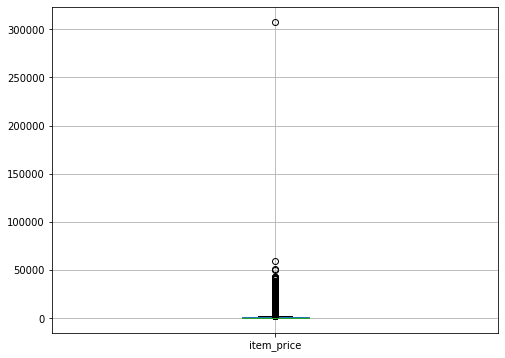

In [57]:
train.boxplot(column = 'item_price', figsize = (8,6))

## Train Preprocessing 

Therefore seeing the above boxplots we can cutoff the outliers 

In [4]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [5]:
train[train['item_price']<0] ## One price item that is below 0 and therefore lets fill it with it the median value of the 
## same month,shop_id, date_block_num

## -1 means a product that has  been returned. We are replacing it for now with the median

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [6]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Based on the eda that others have done it can be seen that some shops are the duplicates of others. Let us take a look into that. The names are in Russian and therefore it is hard for us to pick this up. We shall go by other eda done by Kagglers and fix this in the training and test dataset. 

In [7]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# РостовНаДону ТРК "Мегацентр Горизонт"
train.loc[train.shop_id == 39,'shop_id'] = 40
test.loc[test.shop_id == 39,'shop_id'] = 40

## Shops Preprocessing

Observations:
 - Each shop_name starts with the city name
 - We shall add that as a seperate column along with the another column called city code
 - We also get the shop type from the shop name that can be added as a seperate column
 - We decide to keep only the shop code, city code and shop type

In [8]:
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
## This is one exception from the below
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
#shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
#shops.head()
shops['city_code'] = LabelEncoder().fit_transform(shops['city']) ## Converts the city names into numerical codes
shops = shops[['shop_id','city_code']] ## Deciding to keep only the shop codes,city codes and shop_type in the dataframe. 

## Categories Preprocessing

Observations
- item_cateogry_name is split into two: the type and the subtype
- if the subtype is mising it is filled with type.
- The type and subtype are converted to categories and the item_category_names are removed

In [9]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]
cats

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13
...,...,...,...
79,79,16,54
80,80,16,25
81,81,17,62
82,82,18,63


## Monthly Sales

https://www.kaggle.com/dlarionov/feature-engineering-xgboost/comments

The kaggle kernel that I am following is that with the link above and the coursera course that I did and from the course that I did. In that kernel Dennis explains his approach is that the difference between train and test set is that there are 363 items that are new in the test set. These items sales should created in the training and their sales should be set to 0 in the training set and they should be added to the training set. This is done inorder to make sure that the training set mimics the test set.

We can take a look at items that are not in the training set but that are there in the test set.

In [10]:
len(test[~test.item_id.isin(train.item_id)]['item_id'].unique()),len(test.item_id.unique()), len(test.shop_id.unique()),len(test)

(363, 5100, 42, 214200)

So what we can see from above that there 363 items that are in the training set and that are not there in the test set. The test set has 5100 items out of which 363 items are not there in the training set. There are total of 42 shops in the testing set. This leads to 5100*42 = 2142000. Let's see how that matrix that is created and we shall give show an example for the first date block (January 2013).

In [11]:
#sales = train[train.date_block_num==0] ## For now only the first date block
#matrix = []
#matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
#len(sales.shop_id.unique())*len(sales.item_id.unique()), len(matrix[0]) ## This shows us that the matrix is just a unique 
## combination of each item and shop for each respective date block. The whole loop is done below

NameError: name 'i' is not defined

In [12]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

8.221270561218262

Therefore now we can see above that a dataframe is created with all possible combinations of shop_id and item_id for each date_block. The question I had was why not use a groupby like this.

train.groupby(['dateblocknum','shopid','itemid']).agg({'itemcntday': ['sum']})

This however doesnt capture the test sets characterstics. Now another question is why not form all sorts of possible combinations instead of within the dateblocks.That would lead too many rows(~50 million). Another option is add unique shops and items from the test set to each monthly aggregated block in the training set

The whole ideaa being that total number of values of [len(test.shop_id.unique) * len(test.item_id.unique() = total number of rows in the test dataset]. This siginifies that the other products are not sold in a given shop in a given month

In [13]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [14]:
train.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,2013-02-01,0,59,22154,999.000000,1.0,999.000000
1,2013-03-01,0,25,2552,899.000000,1.0,899.000000
2,2013-05-01,0,25,2552,899.000000,-1.0,-899.000000
3,2013-06-01,0,25,2554,1709.050049,1.0,1709.050049
4,2013-01-15,0,25,2555,1099.000000,1.0,1099.000000


In [15]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # The target has been clipped between 0 and 20 this is because the target values 
                                .astype(np.float16))## in the test set has also been clipped and therefore it is advisable

## se floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. 
## If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs. 

time.time() - ts

## Joining Test Dataset to Training Dataset

In [16]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [17]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34th month (prediction month)
time.time() - ts

0.06151723861694336

## Joining features of Shops/Items/Cats features

In [18]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

3.9582555294036865

In [19]:
matrix.head(5)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,11,4
1,0,2,27,1.0,0,"007 Legends [PS3, русская версия]",19,5,10
2,0,2,28,0.0,0,"007 Legends [PС, Jewel, русская версия]",30,8,55
3,0,2,29,0.0,0,"007 Legends [Xbox 360, русская версия]",23,5,16
4,0,2,32,0.0,0,1+1,40,11,4


## Target Lags

Okay so now lag is a time series concept where we hope try to get patters of sales from the previous months. That is more of like saying does the total items sold in a given month have a pattern to the previous month or 2 months before or a year before. NoW the question how do we how many months of lag should we take into consideration. This more of a trial and error thing. In SARIMA models we could plot ACF and PACF plots and consider how many months of lag that we need to take. Taking 12 months lag is saying what was the patten the same time the previous year. 

On how to choose lags is more of a trial and error and usually people consider a [1,2,6,12] lags period but this is just a wild guess and it is upto the individual to expeirment. I am using this because of the previous kernels that I have seen and the time they took to compute for different lag features

Note: Here we are joining the matrix dataframe and shifted dataframe by columns of date_block_num,shop_id and item_id. This would lead to a question whether a in a given month the shops and items sold wont be the same when compared to the previous month. This is correct and this would lead to a lot Nan's. You can check it for yourself. We would be dealing with this towards the end and turning them to mostly 0

In [20]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [21]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

27.410614490509033

## Mean encoded features

The first mean encoded feature is that of the average sales per month and this is added to the training columns with a lag of 1. What that means is that the value of the previous months averge sales is added as an additional feature to the current months

In [22]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

9.630402326583862

Part - 2 
The next mean encodings is for a combination of date and item_id and then finding the item_cnt_month mean with a lag for [1,2,3,6,12] months. It calculates the at fist the average the number of items that are sold for a given item id in a given date block.

It then calculates the lag for that given average number of items sold in the previous month and the previuos 2 months and so on (max is 12 months). Note: here  while creating the intial average items across each month for a given item id it doesnt do it so for each shop. But this wouldnt be a problem with the lag function which takes into account the shop id as a feature while merging. The shops function would have the average value from the group dataframe that was merged with only dateblock and item_id and therefore shops arent considered there and they would have the same average value from the corresponding item id and date_block. 

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

34.10994839668274

Part - 3 
The next mean encodings is for a combination of date and shop_id and then finding the item_cnt_month mean with a lag for [1,2,3,6,12] months. It calculates the at fist the average the number of items that are sold for a given shop id in a given date block.

It then calculates the lag for that given average number of items sold in the previous month and the previuos 2 months and so on (max is 12 months). that corresponds with the corresponding date_block,shop_id and item_id(from the lag function). Note: here  while creating the intial average items across each month for a given shop id it doesnt do it so for each item id. But this wouldnt be a problem with the lag function which takes into account the item id as a feature while merging. The items_id function would have the average value from the group dataframe that was merged with only dateblock and shops_id and therefore items_id arent considered there and they would have the same average value from the corresponding shops_id and date_block. 

In [24]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

35.17539739608765

Part - 4 
Look into the above explantions for getting an idea. It is the same principle applied

Mean encodinngs for a combination of date_block_num and iten_cateogory_id

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

12.575934171676636

Part-5

Mean encodings for combinations of date_block_num,shop_id,item_cateogry. (lag only for 1 months is calculated)

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.135004043579102

Part - 6

Mean encodings for combinations of date_block_num,shop_id and type_code. (lag only for 1 month is calculated)

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.156243801116943

Part - 7

Mean ecodings for combination of date_block, shop_id and subtype_code. (lag only for 1 months is calculated)

In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.599367380142212

Part - 8

Mean encodings for date_block_num and city_code. (lag only for 1 month is calculated)

In [29]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.417864322662354

Part - 9

Mean encooding for date_block_num', 'item_id', 'city_code'. (lag only for 1 month is calculated)

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.299243211746216

Part - 10

Mean encodinngs for 'date_block_num', 'type_code'

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.537410259246826

Part - 11

Mean encodings for 'date_block_num', 'subtype_code' 

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.164857149124146

## Trend Features

### price trend for upto the last six months 

In [33]:
ts = time.time()
## Creating a column to get the average price for each item based on its item_id
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

## Creating a column to get the average price for each item based on grouping by date_block_num and item_id
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

## This is an important step because here columns are created for a lag of 1-6 months based on the combination of date_block
## and item_id. Basically this tell us what was the price last month, last 2 months...upto last 6 months of the given item
## of a given date block. 
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')




In the above two lines of code creted only the absolute price for a given item in a given date block for the previous 
1-6 months. In the below code what we are doing is to get the trend. 

That is it indicates the ratio of the avg item price (let it be x1) for the last month to the avg item price (x) for the whole set.Hence, for the last month trend_feature = (x1 - x)/x. for example, if last month price is greather then avg price, then the final value is more then zero (positive trend). if last month price is lesser than avg price, then the value is less than zero (negative trend). finaly, if last month price is close to avg price then the trend will be close to zero because of the existence of items wich were not sold last month I use lags for dateitemavgitemprice property. Thus, if I cant get last month trend I take a trend for two months (x2-x)/x and so on.probably the name of the feature 'deltapricelag' should be 'price_trend'.


In [34]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

In the next few lines of code we are creating a new column to understand what has  been the latest trend of a given product. 
This means we scan through every row of the "matrix" dataframe and find out among delta_price_lag(or price trend is the right name) as to what is the latest trend. We are trying to capture the latest trend.i.e: in the last month, but sometimes a product might not be sold in the Febraury and might have been for Jan, so we take the trend value for 2 months ago..similarly we can go all the way back upto 6 months back for the column which we are going to crete "delta_price_lag"





In [35]:
ts = time.time()
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)
time.time() - ts

Now as to what is the functioning of select_trend it does the work of scanning each row and indentifying the latest_value from the delta_price_lag_1 to delta_price_lag_6. How it works I have given a brief code demo here, that I have taken from stackoverflow

In [328]:
#data = [[1,np.nan,2],[np.nan,3,np.nan],[np.nan,4,5],[np.nan,np.nan,np.nan]]
#df = pd.DataFrame(data, columns = ['A', 'B','C'])

#def func(x):
#    if x.first_valid_index() is None:
#        return None
#    else:
#        return x[x.first_valid_index()]
#df.apply(func, axis=1)



Dropping columns such as date_item_avg_price_lag and delta_price_lag

In [36]:
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

### Last month shop revenue trend

This is similar to the the price trend except that we calculate the revenue trend and then create a lag for only the previous month unlike the previous case where we created it for the last months (1-6). This is obvious because ceach shops latest trend can be seen in the previous month of revenue as there wont be any shops with having a revenue the previous month unlike items that could have been sold the previous month or the one before or upto 6 months.

In [37]:
## Grouping by date_block_num and shop_id and summing the total revenue
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

## Creating a column for the revenue date_shop_revenue
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

## Here we are grouping the revenue values by finding the mean over the shop id
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

## Adding this to the matrix
matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

## Doing the same as above that we did for price
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

## Adding only lag for the previous month
matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

time.time() - ts

## Additional Features

### First feature is adding the month as a seperate column

In [38]:
matrix['month'] = matrix['date_block_num'] % 12

### Adding the number of days (there are no leap years)

In [39]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

### Months since the last sale of each shop/item.

We can use hash table approach here. The idea is pretty simple We create a hash map with a key that is combination of shop_id and item_id and then the value would be date_block_num. If it encounters the same combo later it would subtarct the latest value from the older value and therefore this gives us the latest month approach since an item has been sold in a given a shops

In [45]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

1815.1288537979126

### Months since the last sale of each item.

This is the same approch as before 

In [46]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

2625.9488570690155

### Months since the first sale for each shop/item pair and for item only.

In [49]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

4.66597056388855

### Removing all rows from that are in the date_block_num for the first 11 months

The reason we are doing this is because there is a lot of null values in the first 11 months due to the lag variable form 12 months ago

In [51]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

2.9030025005340576

### Producing lags brings a lot of nulls

In [52]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

C:\Users\kuria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


1.8334836959838867

In [53]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_name', 'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',


In [54]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6567567 entries, 4488710 to 11056276
Data columns (total 41 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_name                             object 
 6   item_category_id                      int8   
 7   type_code                             int8   
 8   subtype_code                          int8   
 9   item_cnt_month_lag_1                  float16
 10  item_cnt_month_lag_2                  float16
 11  item_cnt_month_lag_3                  float16
 12  item_cnt_month_lag_6                  float16
 13  item_cnt_month_lag_12                 float16
 14  date_avg_item_cnt_lag_1               float16
 15  date_ite

In [55]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2: XGBoost 

Reading the data file

In [56]:
data = pd.read_pickle('data.pkl')

Select prefect features

- date_block_num: a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33


- shop_id: unique identifier of a shop


- item_id: unique identifier of a product


- item_cnt_month: sum of total items in a given date block for a given shop for a given item id


- city_code: city code that was extracted from the shops name


- item_category_id: unique identifier of item category


- type code: item category name from cats file is split and the first part is the type code


- subtype_code: item category name from cats file is split and the second part is the sub type code


- item_cnt_month_lag_(1:12): This feature calculates total count of a given item in a given shop the previous 1,2,3,4,5,6 & 12 months. (look at Target value
item_cnt_month_lag_1, item_cnt_month_lag_2, item_cnt_month_lag_3, item_cnt_month_lag_6 , item_cnt_month_lag_12


- date_avg_item_cnt_lag_1 : Calculates the previous month's average sales across all the items and shops and uses it as a         feature


- date_item_avg_item_cnt_lag_(1,2,3,..12): Calcualtes the average item count sold in each dateblock for each item id and then
  finds the lag with the previous months. (See Mean encodings part-2)
date_item_avg_item_cnt_lag_1, date_item_avg_item_cnt_lag_2 , date_item_avg_item_cnt_lag_3, date_item_avg_item_cnt_lag_6, date_item_avg_item_cnt_lag_12 


- date_shop_avg_item_cnt_lag_(1,2,3,..12):  Calcualtes the average item count sold in each dateblock for each shop id and then
  finds the lag with the previous months. (See Mean encodings part-3)
date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2, date_shop_avg_item_cnt_lag_3, date_shop_avg_item_cnt_lag_6, date_shop_avg_item_cnt_lag_12


- date_cat_avg_item_cnt_lag_1 : Calcualtes the average item count sold in each dateblock for each item_category_id and then
  finds the lag with the previous month. (See Mean encodings part-4). (lag is only 1 month here)
  
  
- date_shop_cat_avg_item_cnt_lag_1: Calcualtes the average item count sold  for each date_block_num, shop_id and item_category_id then finds the lag with the previous month. (See Mean encodings part-5). (lag is only 1 month here)

  
- date_shop_type_avg_item_cnt_lag_1:  Calcualtes the average item count sold  for each date_block_num, shop_id and type_code then finds the lag with the previous month. (See Mean encodings part-6). (lag is only 1 month here)


- date_shop_subtype_avg_item_cnt_lag_1:  Calcualtes the average item count sold  for each date_block_num, shop_id and subtype_code then finds the lag with the previous month. (See Mean encodings part-7). (lag is only 1 month here)


- date_city_avg_item_cnt_lag_1:  Calcualtes the average item count sold  for each date_block_num and city_code then finds the lag with the previous month. (See Mean encodings part-7). (lag is only 1 month here)


- date_item_city_avg_item_cnt_lag_1: Calcualtes the average item count sold  for each date_block_num, item_id and city_code and then finds the lag with the previous month. (See Mean encodings part-8). (lag is only 1 month here)

 
- date_type_avg_item_cnt_lag_1: Calcualtes the average item count sold  for each date_block_num and type_code and then finds the lag with the previous month. (See Mean encodings part-9). (lag is only 1 month here)


- date_subtype_avg_item_cnt_lag_1: Calcualtes the average item count sold  for each date_block_num and subtype_code and then finds the lag with the previous month. (See Mean encodings part-9). (lag is only 1 month here)


- delta_price_lag: latest trend for the price of a given item for the latest available month


- delta_revenue_lag_1: latest trend for the revenue of a shop for latest avaialbe month


- month


- days


- item_shop_last_sale: Months since the last sale of each shop and each item inside that shop


- item_last_sale: Months since the last sale of each item.


- item_shop_first_sale: Months since the first sale of each shop and each item inside that shop


- item_first_sale: Months since the first sale of each item.



In [57]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]


Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [58]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [59]:
del data
gc.collect();


In [60]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[13:03:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.05562	validation_1-rmse:1.03995
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.96630	validation_1-rmse:0.97640
[2]	validation_0-rmse:0.91805	validation_1-rmse:0.94666
[3]	validation_0-rmse:0.88766	validation_1-rmse:0.92791
[4]	validation_0-rmse:0.86766	validation_1-rmse:0.91744
[5]	validation_0-rmse:0.85601	validation_1-rmse:0.91326
[6]	validation_0-rmse:0.84850	validation_1-rmse:0.91007
[7]	validation_0-rmse:0.84213	validation_1-rmse:0.90667
[8]	validation_0-rmse:0.83812	validation_1-rmse:0.90552
[9]	validation_0-rmse:0.83504	validation_1-rmse:0.90510
[10]	validatio

279.46630096435547

In [61]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

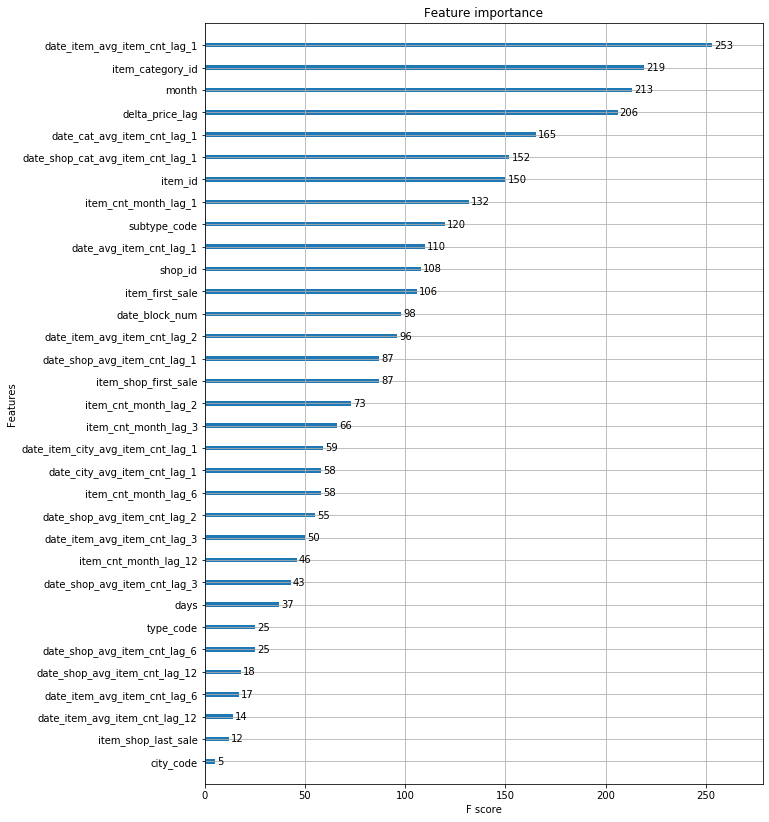

In [69]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))